In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
env = gym.make('MountainCar-v0')

In [70]:
LEARNING_RATE = 0.1
NUM_EPISODES = 500
DISCOUNT_FACTOR = 0.95

In [4]:
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high-env.observation_space.low)/DISCRETE_OS_SIZE[0]

In [41]:
#q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE+[env.action_space.n]))
q_table_1 = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE+[env.action_space.n]))
q_table_2 = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE+[env.action_space.n]))

In [6]:
def get_discrete_state(state):
    discrete_state = (state-env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

In [67]:
def make_epsilon_greedy_policy(epsilon, q_table_1, q_table_2):
    def policy_fn(state):
        q_table_avg = {}
        for i in range(20):
            for j in range(20):
                q_table_avg[(i,j)] = (q_table_1[(i,j)] + q_table_2[(i,j)])/2
        
        actions = q_table_avg[state]
        A = np.ones(len(actions), dtype=float) * (epsilon / len(actions))
        best_action = np.argmax(actions)
        A[best_action] += 1 - epsilon
        
        return A
    return policy_fn

In [71]:
policy = make_epsilon_greedy_policy(0.05, q_table_1, q_table_2)
episode_lengths = [0] * NUM_EPISODES
episode_rewards = [0] * NUM_EPISODES

for i_episode in range(NUM_EPISODES):
    state = env.reset()
    done = False 
    if (i_episode+1) % 100 == 0:
        print('\r', i_episode+1, end='')
        sys.stdout.flush()
    while not done: 
        #if i_episode % 100 == 0:
        #    env.render()
        discrete_state = get_discrete_state(state)
        action_probs = policy(discrete_state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(action)
        episode_lengths[i_episode] += 1
        episode_rewards[i_episode] += reward
        if not done:
            discrete_next_state = get_discrete_state(next_state)
            if np.random.random() > 0.5:
                best_next_q_value = q_table_2[discrete_next_state][np.argmax(q_table_1[discrete_next_state])]
                target = reward + DISCOUNT_FACTOR * best_next_q_value
                q_table_1[discrete_state][action] += LEARNING_RATE * (target - q_table_1[discrete_state][action])
            else:
                best_next_q_value = q_table_1[discrete_next_state][np.argmax(q_table_2[discrete_next_state])]
                target = reward + DISCOUNT_FACTOR * best_next_q_value
                q_table_2[discrete_state][action] += LEARNING_RATE * (target - q_table_2[discrete_state][action])
                
        elif next_state[0] >= env.goal_position:
            q_table_1[discrete_state][action] = 0
            q_table_2[discrete_state][action] = 0
        
        state = next_state  

 500

In [74]:
# Use this with the trainining function from DQN-file
class QAgent:
    def __init__(self, env):
        self.epsilon = 0.5
        self.epsilon_max = 0.5
        self.epsilon_min = 0.1
        self.epsilon_decay = (self.epsilon_max - self.epsilon_min) / 1000
        self.discount_factor = 0.95
        self.learning_rate = 0.1
        self.state_size = len(env.observation_space.high)
        self.action_size = env.action_space.n
        self.discrete_table_size = 20
        self.q_table = self.build_model()
    
    def build_model(self):
        table_size = [self.discrete_table_size] * self.state_size
        q_table = np.random.uniform(low=-2, high=0, size=(table_size+[self.action_size]))
        return q_table
    
    def get_discrete_state(self, state):
        normalized_state = (state - env.observation_space.low) / (env.observation_space.high - env.observation_space.low)
        rescaled_state = normalized_state * self.discrete_table_size
        return tuple(rescaled_state.astype(np.int))
    
    def act(self, state):
        if self.epsilon_max >= self.epsilon >= self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        discrete_state = self.get_discrete_state(state)
        if np.random.random() > self.epsilon:
            q_values = self.q_table[discrete_state]
            return np.argmax(q_values)
        else:
            return np.random.choice(np.arange(self.action_size))
          
    def update(self, state, action, reward, next_state, done):
        discrete_state = self.get_discrete_state(state)
        if next_state[0] >= env.goal_position:
            self.q_table[discrete_state][action] = 0
        else:
            discrete_next_state = self.get_discrete_state(next_state)
            best_next_q_value = np.max(self.q_table[discrete_next_state])
            target = reward + self.discount_factor * best_next_q_value
            self.q_table[discrete_state][action] += self.learning_rate * (target - self.q_table[discrete_state][action])

array([[[-1.15597058e+00, -1.29296579e+00, -5.28019041e-02],
        [-1.92321420e-02, -1.80144255e+00, -1.24503709e+00],
        [-1.27660411e+00, -1.48896662e+00, -1.71002592e+00],
        ...,
        [-2.58772315e-02, -1.01235245e+00, -6.88126324e-01],
        [-1.17262703e+00, -1.78394067e+00, -1.43538409e+00],
        [-4.06205437e-01, -1.72373334e+00, -6.60010254e-02]],

       [[-1.82150330e+00, -7.43908025e-02, -1.45128033e+00],
        [-1.18746394e+00, -6.80604055e-01, -1.10209700e-01],
        [-7.54682191e-01, -1.56125781e+00, -5.37787302e-01],
        ...,
        [-4.60778409e-01, -1.57872967e+00, -8.53295183e-04],
        [-1.64782912e+00, -9.12911181e-01, -1.90510844e+00],
        [-8.39867573e-01, -4.54701581e-01, -1.63072115e+00]],

       [[-9.91313920e-01, -2.82609371e-01, -8.24628765e-01],
        [-7.24914202e-01, -1.88685966e+00, -6.88133977e-01],
        [-9.85154456e-01, -4.65964019e-01, -5.80560620e-01],
        ...,
        [-5.09833998e-01, -4.21625107e-01,

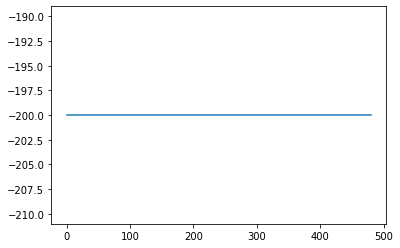

In [72]:
x_double = np.convolve(episode_rewards, np.ones((20,))/20, mode='valid')
fig = plt.plot(x_double)
plt.show()

In [30]:
x = np.convolve(episode_rewards, np.ones((20,))/20, mode='valid')

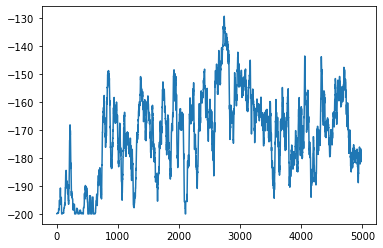

In [33]:
fig = plt.plot(x)
plt.show()

ValueError: Argument Z must be 2-dimensional.

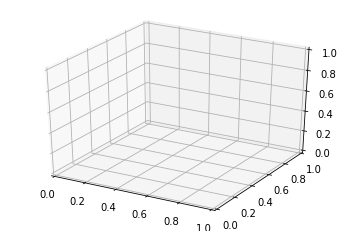

In [77]:
fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.arange(20)
y = np.arange(20)
X, Y = np.meshgrid(x, y)
ax.plot_wireframe(X, Y, q_table, color='green')
plt.show()


In [65]:
q_table_avg = {}
for i in range(20):
    for j in range(20):
        q_table_avg[(i,j)] = (q_table_1[(i,j)] + q_table_2[(i,j)])/2


In [66]:
q_table_avg

{(0, 0): array([-1.54588913, -1.30489767, -0.55500387]),
 (0, 1): array([-0.56832732, -1.32784945, -1.32493754]),
 (0, 2): array([-1.18986981, -1.10870527, -1.6074571 ]),
 (0, 3): array([-0.99058288, -1.2138047 , -1.18762481]),
 (0, 4): array([-1.28493933, -1.65015092, -0.89312713]),
 (0, 5): array([-1.00422257, -1.25256407, -1.09587694]),
 (0, 6): array([-1.06228255, -0.33862019, -1.11140519]),
 (0, 7): array([-0.87482358, -1.15644934, -1.57323883]),
 (0, 8): array([-1.08264789, -0.56121195, -1.42982094]),
 (0, 9): array([-0.80498672, -1.04442889, -1.76409225]),
 (0, 10): array([-1.51704168, -0.79987435, -1.73221776]),
 (0, 11): array([-0.89094749, -0.83806852, -0.56987199]),
 (0, 12): array([-0.81457741, -1.30407976, -1.02140803]),
 (0, 13): array([-1.25074812, -0.83858812, -1.31431802]),
 (0, 14): array([-0.46075338, -0.72629989, -0.98922233]),
 (0, 15): array([-0.72903438, -0.46696994, -0.59941857]),
 (0, 16): array([-1.41567435, -1.19527285, -0.37850201]),
 (0, 17): array([-0.7648